In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("shopping_trends.csv").filter(['Age','Frequency of Purchases'])
print(df)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print(train_df, test_df)

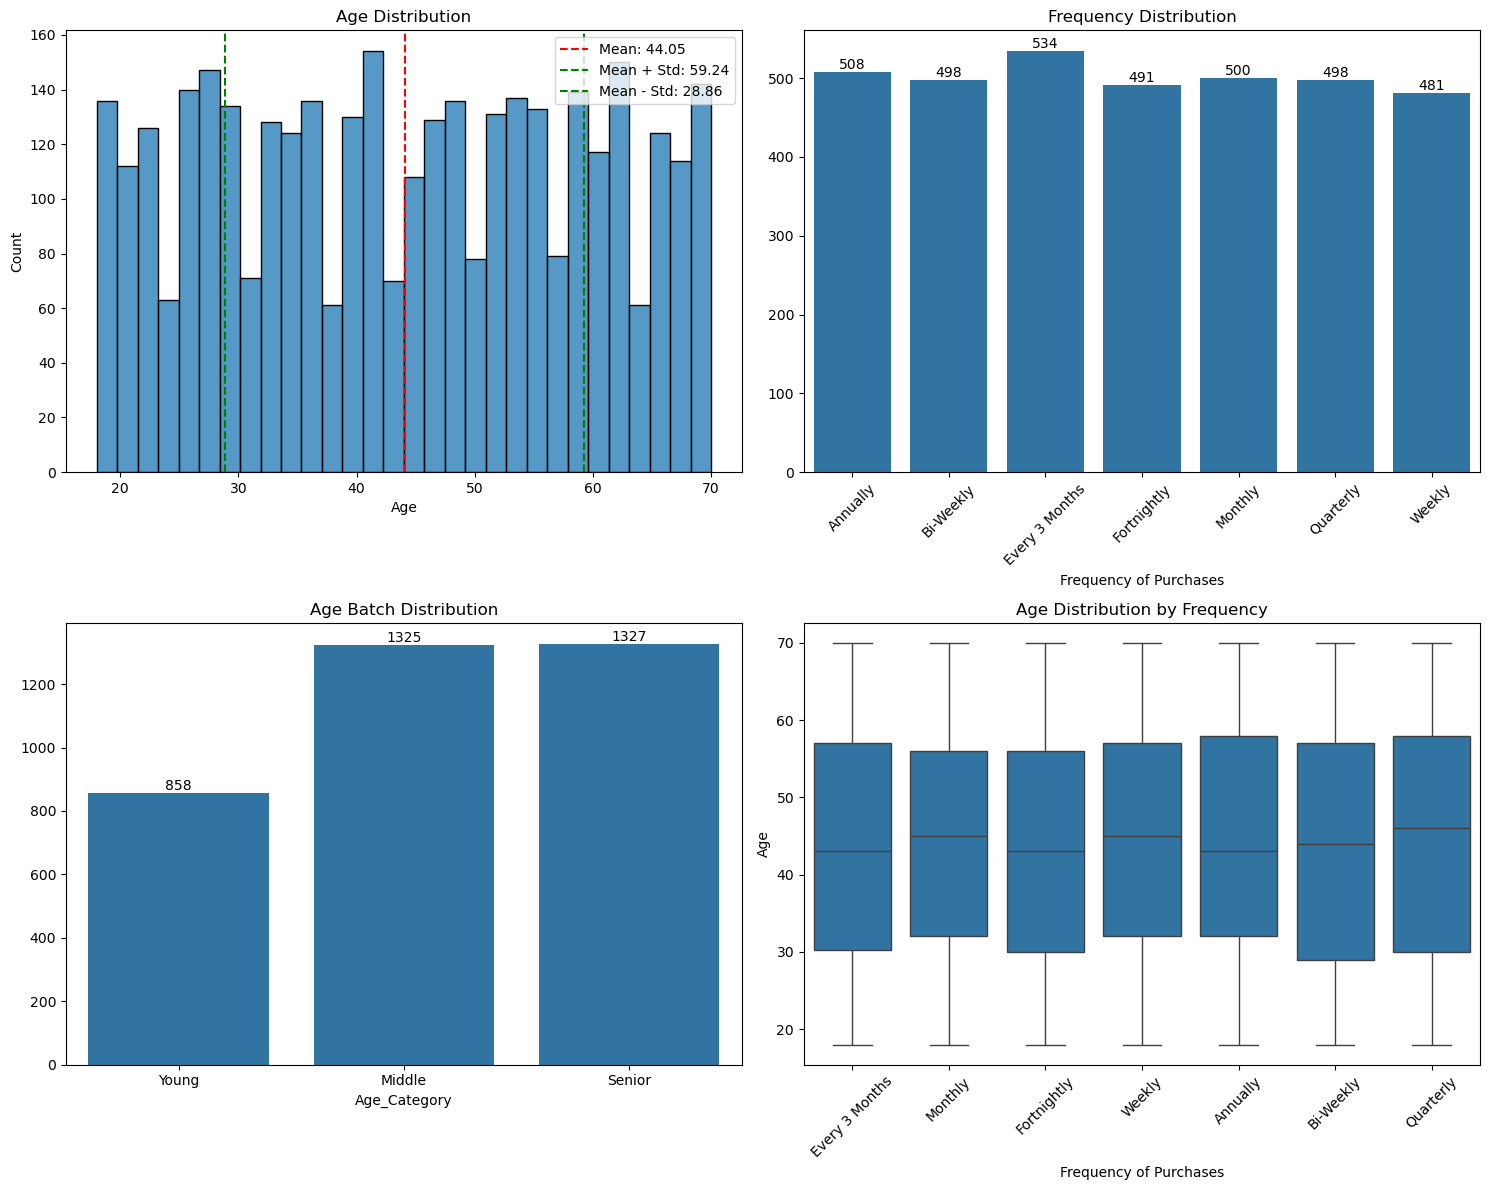


Age Statistics:
Mean: 44.05
Standard Deviation: 15.19
Min: 18
Max: 70

Frequency distribution by Age Category:
Frequency of Purchases  Annually  Bi-Weekly  Every 3 Months  Fortnightly  \
Age_Category                                                               
Young                        114        140             134          127   
Middle                       199        173             211          184   
Senior                       195        185             189          180   

Frequency of Purchases  Monthly  Quarterly  Weekly  
Age_Category                                        
Young                       111        130     102  
Middle                      202        161     195  
Senior                      187        207     184  

Frequency Distribution:
Frequency of Purchases
Annually          508
Bi-Weekly         498
Every 3 Months    534
Fortnightly       491
Monthly           500
Quarterly         498
Weekly            481
Name: count, dtype: int64


In [28]:
# Tạo figure với 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Phân phối của Age
sns.histplot(data=train_df, x='Age', bins=30, ax=ax1)
ax1.set_title('Age Distribution')
ax1.axvline(train_df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["Age"].mean():.2f}')
ax1.axvline(train_df['Age'].mean() + train_df['Age'].std(), color='green', linestyle='--', 
            label=f'Mean + Std: {train_df["Age"].mean() + train_df["Age"].std():.2f}')
ax1.axvline(train_df['Age'].mean() - train_df['Age'].std(), color='green', linestyle='--',
            label=f'Mean - Std: {train_df["Age"].mean() - train_df["Age"].std():.2f}')
ax1.legend()

# Plot 2: Phân phối của Frequency
freq_counts = train_df['Frequency of Purchases'].value_counts().sort_index()
sns.barplot(x=freq_counts.index, y=freq_counts.values, ax=ax2)
ax2.set_title('Frequency Distribution')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(freq_counts.values):
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Tạo df mới với age batch
train_df_batch = train_df.copy()
train_df_batch['Age_Category'] = pd.cut(train_df_batch['Age'], 
                                      bins=[0, 30, 50, float('inf')],
                                      labels=['Young', 'Middle', 'Senior'])

# Plot 3: Phân phối của Age Batch
age_batch_counts = train_df_batch['Age_Category'].value_counts().sort_index()
sns.barplot(x=age_batch_counts.index, y=age_batch_counts.values, ax=ax3)
ax3.set_title('Age Batch Distribution')
for i, v in enumerate(age_batch_counts.values):
    ax3.text(i, v, str(v), ha='center', va='bottom')

# Plot 4: Boxplot của Age theo Frequency
sns.boxplot(data=train_df, x='Frequency of Purchases', y='Age', ax=ax4)
ax4.set_title('Age Distribution by Frequency')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# In thống kê về Age
print("\nAge Statistics:")
print(f"Mean: {train_df['Age'].mean():.2f}")
print(f"Standard Deviation: {train_df['Age'].std():.2f}")
print(f"Min: {train_df['Age'].min()}")
print(f"Max: {train_df['Age'].max()}")

# In phân phối của Frequency of Purchases theo Age Category
print("\nFrequency distribution by Age Category:")
print(pd.crosstab(train_df_batch['Age_Category'], train_df_batch['Frequency of Purchases']))

# In phân phối của Frequency
print("\nFrequency Distribution:")
print(freq_counts)

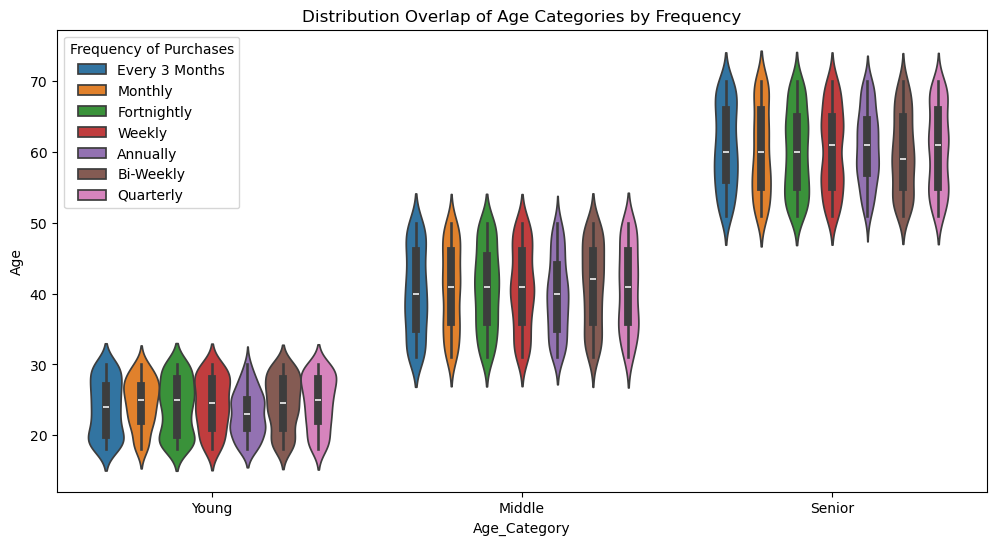


Conditional Probabilities P(Frequency|Age_Category):
Frequency of Purchases  Annually  Bi-Weekly  Every 3 Months  Fortnightly  \
Age_Category                                                               
Young                   0.132867   0.163170        0.156177     0.148019   
Middle                  0.150189   0.130566        0.159245     0.138868   
Senior                  0.146948   0.139412        0.142427     0.135644   

Frequency of Purchases   Monthly  Quarterly    Weekly  
Age_Category                                           
Young                   0.129371   0.151515  0.118881  
Middle                  0.152453   0.121509  0.147170  
Senior                  0.140919   0.155991  0.138659  


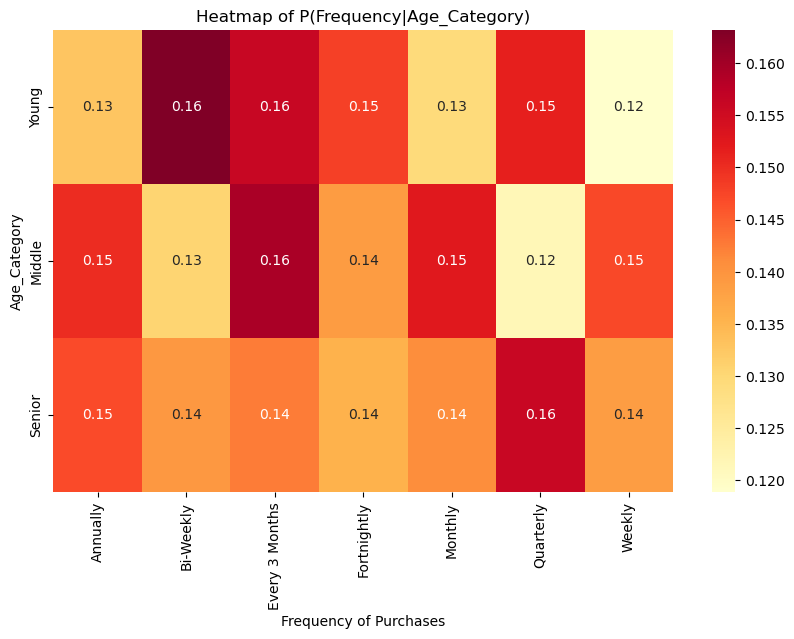

In [29]:
# Tạo violin plot để thấy rõ sự overlap
plt.figure(figsize=(12, 6))
sns.violinplot(data=train_df_batch, x='Age_Category', y='Age', hue='Frequency of Purchases')
plt.title('Distribution Overlap of Age Categories by Frequency')
plt.show()

# Tính conditional probabilities để thấy rõ hơn về overlap
cond_prob = pd.crosstab(train_df_batch['Age_Category'], 
                        train_df_batch['Frequency of Purchases'], 
                        normalize='index')
print("\nConditional Probabilities P(Frequency|Age_Category):")
print(cond_prob)

# Tạo heatmap để visualize conditional probabilities
plt.figure(figsize=(10, 6))
sns.heatmap(cond_prob, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Heatmap of P(Frequency|Age_Category)')
plt.show()